In [144]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [145]:
df = pd.read_csv("../DATA/us_gasoline.csv")
df.ds = pd.to_datetime(df.ds)
df.tail()

,unique_id,ds,y
1350,us_gasoline,2016-12-19,9.278
1351,us_gasoline,2016-12-26,8.465
1352,us_gasoline,2017-01-02,8.470
1353,us_gasoline,2017-01-09,8.069
1354,us_gasoline,2017-01-16,8.039


In [146]:
metrics = {"Crossval RMSE": [], "Test RMSE": []}

for i in range(30):
    new_df = trend(df, freq="W")[0]
    new_df = fourier(new_df, freq="W", k=i, season_length=52)[0]
    train = new_df[new_df.ds.dt.year < 2004]
    test = new_df[new_df.ds.dt.year == 2004]

    X_train = train.drop(columns=["unique_id", "ds", "y"])
    y_train = train.y

    X_test = test.drop(columns=["unique_id", "ds", "y"])
    y_test = test.y

    linreg = LinearRegression().fit(X_train, y_train)
    y_pred = linreg.predict(X_test)

    crossval_rmse = -np.mean(
        cross_val_score(
            LinearRegression(),
            X_train,
            y_train,
            cv=TimeSeriesSplit(n_splits=10, test_size=len(X_test)),
            scoring="neg_root_mean_squared_error",
        )
    )

    test_score = root_mean_squared_error(y_test, y_pred)
    metrics["Crossval RMSE"].append(crossval_rmse)
    metrics["Test RMSE"].append(test_score)
print(pd.Series(metrics))

Crossval RMSE    [0.3561122088667774, 0.30116603559415234, 0.30024589256232026, 0.2922135172539617, 0.29172108756...
Test RMSE        [0.24972035335043852, 0.20819287869061545, 0.20598068577324033, 0.19755002764350227, 0.190927652...
dtype: object


<Axes: >

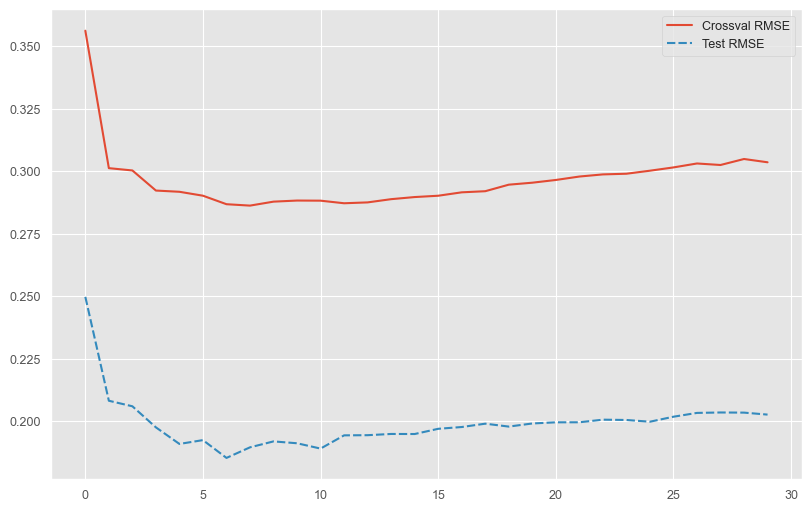

In [147]:
sns.lineplot(metrics)

In [148]:
new_df = trend(df, freq="W")[0]
new_df = fourier(new_df, freq="W", k=6, season_length=52)[0]
train = new_df[new_df.ds.dt.year < 2004]
test = new_df[new_df.ds.dt.year == 2004]

X_train = train.drop(columns=["unique_id", "ds", "y"])
y_train = train.y

X_test = test.drop(columns=["unique_id", "ds", "y"])
y_test = test.y

linreg = LinearRegression().fit(X_train, y_train)
resid = y_train - linreg.predict(X_train)
y_pred = linreg.predict(X_test)

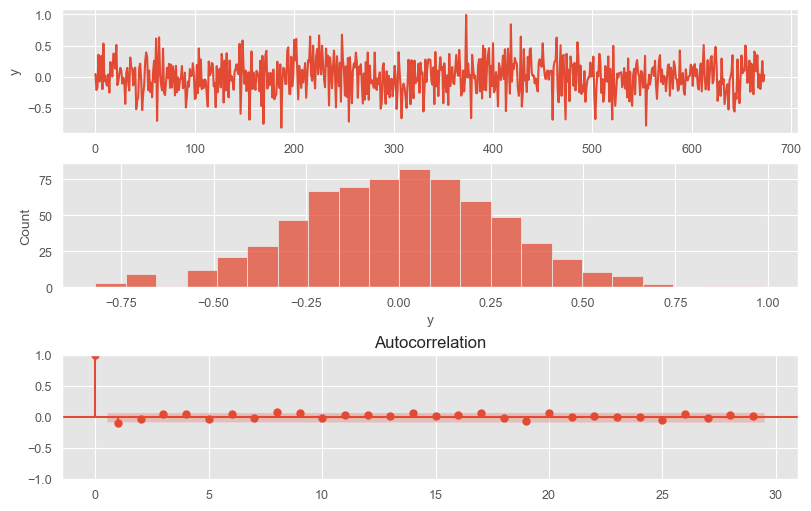

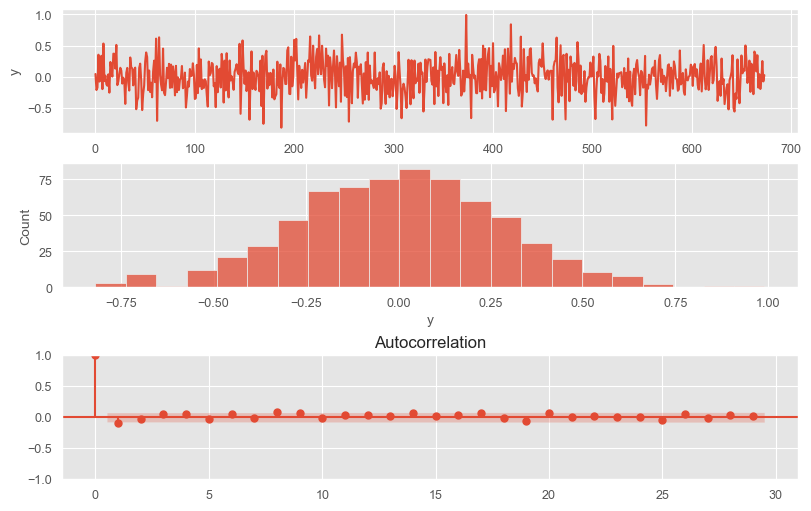

In [149]:
_, axes = plt.subplots(3, 1)
sns.lineplot(resid, ax=axes[0])
sns.histplot(resid, ax=axes[1])
plot_acf(resid, ax=axes[2])

In [150]:
acorr_ljungbox(resid.dropna())

,lb_stat,lb_pvalue
1,5.234,0.022
2,5.528,0.063
3,7.405,0.060
4,8.881,0.064
5,9.335,0.096
6,10.830,0.094
7,10.951,0.141
8,15.526,0.050
9,18.917,0.026
10,19.015,0.040


<Axes: xlabel='1', ylabel='y'>

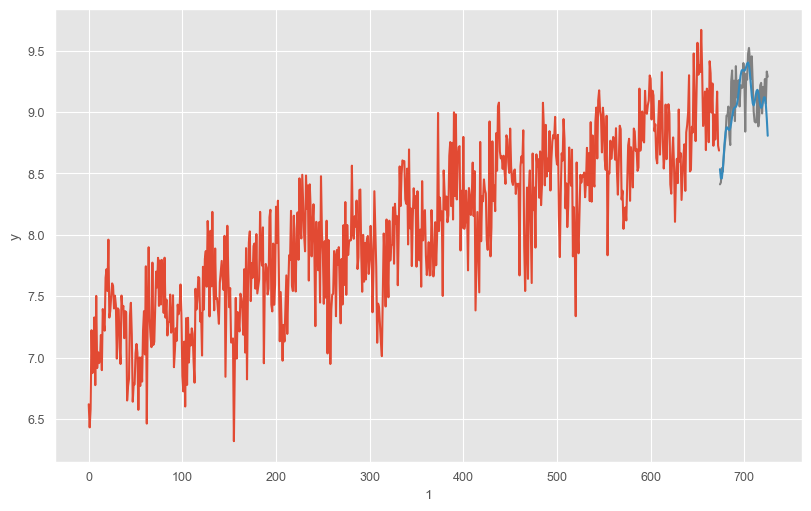

In [167]:
ctmp = pd.DataFrame([y_pred, list(range(674, 674+len(y_pred)))]).T

sns.lineplot(y_train)
sns.lineplot(y_test, color='gray')
sns.lineplot(tmp, y=tmp[0], x=tmp[1])

In [160]:
pd.DataFrame([y_pred, list(range(674, 674 + len(y_pred)))]).T

,0,1
0,8.534,674.0
1,8.460,675.0
2,8.460,676.0
3,8.529,677.0
4,8.640,678.0
5,8.753,679.0
6,8.836,680.0
7,8.874,681.0
8,8.874,682.0
9,8.859,683.0
